# Generate infection network

In [1]:
import pandas as pd
import matplotlib.colors
import matplotlib.pyplot as plt
%matplotlib inline
import networkx as nx

## 0. Paths

In [2]:
HUMANS_PATH     = '../outputs/testing-humans_time_course.csv'
INFECTIONS_PATH = '../outputs/InfectionNetwork.csv'
EXPORT_GML_PATH = '../outputs/network_static.gml'

## 1. Read outputs

NOTE: currently the humans and the infections are not from the same simulation!

Humans timecourses:

In [3]:
humans_tc = pd.read_csv(HUMANS_PATH)

Get rid of `Unnamed: 0`:

In [4]:
humans_tc = humans_tc[['h_ID', 'loc', 'status', 'WasInfected', 'Diagnosed', 'Hospitalized', 'ICUed', 'time']]

In [5]:
humans_tc.head()

,h_ID,loc,status,WasInfected,Diagnosed,Hospitalized,ICUed,time
0,214,230,S,0,0,0,0,1
1,172,200,S,0,0,0,0,1
2,285,304,S,0,0,0,0,1
3,179,203,S,0,0,0,0,1
4,187,209,S,0,0,0,0,1


In [6]:
humans_tc.shape

(72400, 8)

Infection network:

In [7]:
infections = pd.read_csv(INFECTIONS_PATH)

Get rid of `Unnamed: 0`:

In [8]:
infections = infections[['ID', 'place_of_infection', 'time_of_infection', 'got_infected_by']]

Convert `got_infected_by` to `int`:

Using `pd.Int32Dtype()` in order to keep `NaN`s.

In [9]:
infections['got_infected_by'] = infections['got_infected_by'].astype(pd.Int32Dtype())

In [10]:
infections.head()

,ID,place_of_infection,time_of_infection,got_infected_by
0,161,34,12,594
1,485,609,1,486
2,845,20,10,548
3,305,20,9,137
4,557,717,2,561


In [11]:
infections.shape

(847, 4)

## 2. Generate static network

Network up to a certain time:

In [12]:
cutoff_time = 5

In [13]:
infections_trimmed = infections[infections['time_of_infection'] <= cutoff_time]

Generate edge list:

In [14]:
infection_events = list(zip(infections_trimmed['got_infected_by'], infections_trimmed['ID']))

Generate graph:

In [15]:
infection_network_static = nx.DiGraph(infection_events)

Add all nodes so that not just the infected are in the graph:

In [16]:
infection_network_static.add_nodes_from(humans_tc['h_ID'])
# infection_network_static.add_nodes_from(range(1000))

Draw graph:

In [17]:
edges = infection_network_static.edges()

In [18]:
len(edges)

298

In [19]:
out_degrees = [infection_network_static.out_degree()[edge[0]] for edge in edges]

In [20]:
max(out_degrees)

4

Define a colormap based on the degrees of the nodes:

In [21]:
cdict = {'red':   [(0.0, 0.0, 0.0),  # red increases
                   (1.0, 1.0, 1.0)],

         'green': [(0.0, 1.0, 1.0),  # green decreases
                   (1.0, 0.0, 0.0)],

         'blue':  [(0.0, 0.0, 0.0),  # no blue at all
                   (1.0, 0.0, 0.0)]}

red_green_cm = matplotlib.colors.LinearSegmentedColormap('RedGreen', cdict, max(out_degrees))

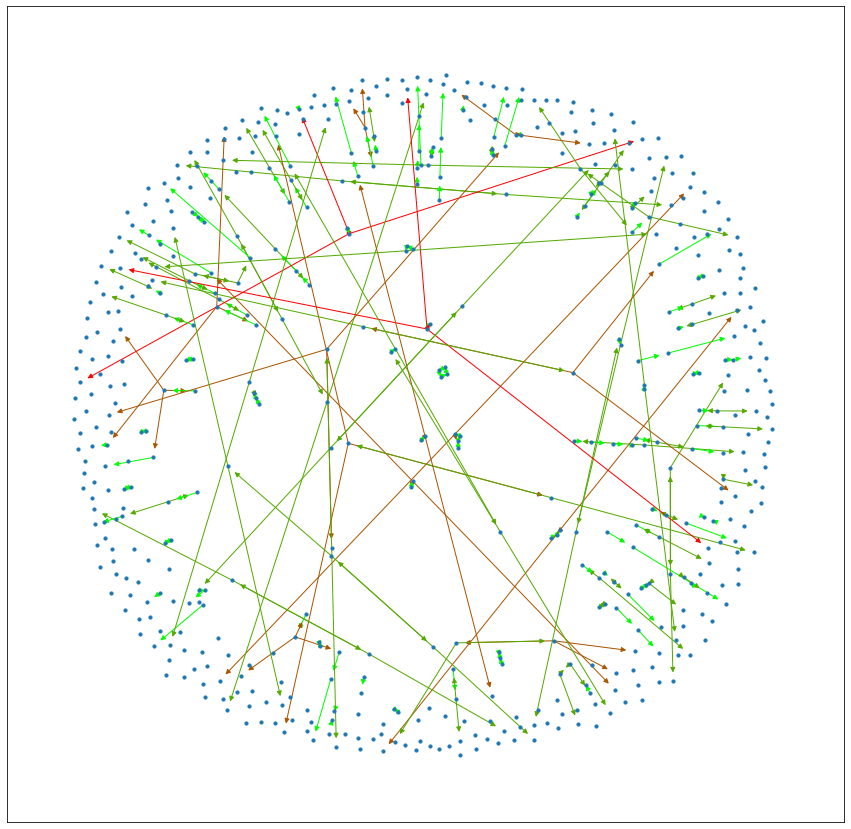

In [22]:
plt.figure(figsize = (15, 15))
pos = nx.spring_layout(infection_network_static)
nx.draw_networkx_nodes(infection_network_static, pos, node_size = 10)
nx.draw_networkx_edges(infection_network_static, pos, edge_color = out_degrees, edge_cmap = red_green_cm, arrows = True)
plt.show()

Save network to `gml` (e.g. for visualization in Cytoscape):

In [23]:
to_string = lambda x: str(x)

nx.write_gml(infection_network_static, path = EXPORT_GML_PATH, stringizer = to_string)